## Desarrollo:
    hecho - Explicar los métodos numéricos (CMM,WP,?)  
    - Se deben mencionar los pasos que siguieron para implementar los algoritmos, las dificultades que fueron encontrando y la descripci ́on de c ́omo las fueron resolviendo.   
    -incluir explicacion de por que el algoritmo funciona correctamente utilizando CMM    
    -alternativas consideradas y descartadas para cada uno de los métodos utilizados (CMM, WP, Keener)   


### Características estudiadas:  
1. C es estrictamente diagonal dominante  
2. Al ser una matriz estrictamente diagonal dominante, esta es inversible y tiene una única solución. Como tiene una única solución, no será necesario hacer ningún intercambio de filas o columnas durante la EG ya que no tendremos ecuaciones sin solución o infinitas soluciones.  
3. ?  


## Metodos numericos utilizados  



### Metodo Colley Matrix (CMM)




Se trata de un metodo que toma de cada partido jugado, \'unicamente qui\'enes fueron los participantes y qui\'en gan\'o. Acumula los partidos jugados de cada equipo, los partidos jugados por un equipo contra otro (puede repetirse un partido con los mismos equipos), los partidos ganados por cada equipo y los partidos perdidos por cada equipo en las variables $n_i$, $n_ij$, $w_i$ y $l_i$ respectivamente, donde $i$ y $j$ son sobindices que denotan a los equipos. 
Con estas variables, se construye un sistema lineal $Cr = b$ donde:  

\begin{equation}C_{ij}= \left\{ \begin{array}{lcc}
             -n_{ij} &   si  & i \neq j \\
             \\2 + n_i &  si  & i = j
             \end{array}
   \right.\end{equation}\\
   
Y $b$ es un vector donde cada componente $b_i = 1 + (w_i + l_i)/2$. La soluci\'on del sistema $r$ es un vector donde cada componente $r_i$ es el rating del equipo i-\'esimo.  
Ordenando los ratings, se obtiene el ranking.  
El vector $r$ es construido como un estimador de la probabilidad de que el i-esimo equipo gane el proximo partido, m\'as especificamente:  

\begin{equation}r_i = \frac{1 + w_i}{2 + n_i}\end{equation} 

Donde los sumandos del numerador y el denominador se utilizan para modelar de mejor manera las probabilidades de equipos con ninguno o pocos partidos jugados, basados en la regla de sucesion de Laplace (observese que cuando un equipo no ha jugado partidos, su probabilidad de ganar se modela con 1/2 y a medida que aumentan los partidos jugados los efectos de los sumandos se disipan).  
Este metodo no considera la posibilidad del empate entre equipos, de modo que la anterior igualdad se puede desarrollar del siguiente modo...

\begin{equation}\frac{1 + w_i}{2 + n_i} = \frac{1+w_i}{2+w_i+n_i}\end{equation}  

Por otro lado, considerando que $n_i = w_i + l_i$, podemos reescribir a $w_i$ como:  
\begin{equation} w_i = \frac{w_i - l_i}{2} + \frac{n_i}{2} \\
                     = \frac{w_i - l_i}{2} + \frac{\sum_{j=1}^{n_i}{1}}{2} \\
                     \approx \frac{w_i - l_i}{2} + \sum_{j=1}^{n_i}{r_i^j}  \end{equation}

Tenemos por ahora entonces que
\begin{equation} w_i
                     \approx \frac{w_i - l_i}{2} + \sum_{j=1}^{n_i}{r_i^j}  \end{equation} y ademas \begin{equation}r_i = \frac{1 + w_i}{2 + n_i}\end{equation} 

Si despejamos...

\begin{equation} (2 + n_i) r_i - \sum_{j=1}^{n_i}{r_i^j}  = 1 + \frac{w_i-l_i}{2}\end{equation}

Lo cual nos lleva a nuestro sistema inicial planteado $Cr=b$.



### Win percentage (WP)

Este metodo modela el rating de cada equipo simplemente como $r_i = w_i / n_i$, y obtiene el ranking a partir de ordenar el vector de ratings $r$.

### Keener Method

El metodo de Keener ya no tiene en cuenta quien gano o perdio, sino mas bien la cantidad de puntos que un equipo anoto frente a otro. 
Se construye una matriz $K$ donde cada componente $K_{ij}$ es una funcion de los puntos de $i$ contra $j$ y los puntos de $j$ contra $i$, denotados por $S_{ij}$ y $S_{ji}$ respectivamente.


\begin{equation}K_{ij}= \left\{ \begin{array}{lcc}
             h(\frac{S_{ij} + 1}{S_{ij} + S_{ji} + 2}) &   si  \: i \: y \: j \: se \: enfrentaron \\
             \\0 &    caso \: contrario \
             \end{array}
   \right.\end{equation}\

   Donde $h(h) = 1/2 + (1/2) \: sgn(x-1/2) \sqrt{|2x-1|}$ es la "funcion suavizadora de Keener", cuyo objetivo es que el rendimiento de los goles sobre el incremento en el ranking sea decreciente (vease grafico de h).

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import math
def h(x):
    return (0.5+ 0.5 * np.sign(x-0.5) * np.sqrt(abs(2*x-1)))

<AxesSubplot:>

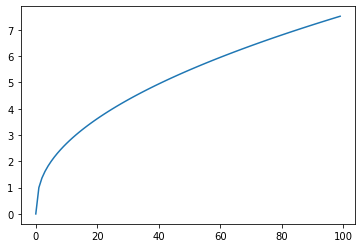

In [11]:
dom = np.arange(0,100,1)
im = pd.Series([h(x) for x in dom])
im.plot.line(dom)



El rating de los equipos se obtiene resolviendo el sistema $K r = \lambda r$ donde $r$ es el autovalor dominante de la matriz $K$. Ordenando las componentes $r_i$ se obtiene el ranking.

### Implementacion de los algoritmos, pasos


#### CMM

1. Se definen una matriz de doubles $C$ y un vector de doubles $B$, inicializados nulos.
2. Se itera con una variable $i$ en el rango $[0, n)$ y a cada iteracion se suma 1 al elemento i-esimo de $B$ y se le suma 2 al elemento $C_{ii}$ (de la diagonal).
3. Se crea un bucle que extrae los datos de un partido, distingue quien es el perdedor (l) y el ganador (w), decrementa $C_{w,l}$ y $C_{l,w}$, se incrementan $C_{l,l}$ y $C{w,w}$ y finalmente se incrementa B_{w} en 0.5 y se decrementa B_{l} en 0.5. 
4. Tenemos construida la matriz de Colley y el vector $b$ del sistema propuesto.
5. Se aplica eliminacion gaussiana sobre la matriz aumentada $C|b$, obteniendose una triangulacion de $C$ y la $b$ correspondiente a la triangulacion.
6. Se aplica backward substitution para obtener el vector de ratings en el vector de doubles $r$.  

<font color = "red">Desarrollar 5 y 6</font>
    

#### Win Percentage
1. Se definen dos vectores de enteros: $Wins$ y $GamesPlayed$, inicializados nulos.
2. A medida que vamos leyendo el archivo de entrada, en $GamesPlayed$ sumaremos 1 en los índices $i$ y $j$, que representan los equipos/jugadores que se enfrentan en esta línea del archivo de entrada.
3. En el vector $Wins$ también sumaremos 1 en la posición del ganador de ese partido, el cual determinamos comparando sus puntajes
4. Creamos el vector resultado $r$, y para cada posición $i$ en el rango $[0, n)$ le asignamos a $r_i$ el resultado de hacer $Wins_i / GamesPlayed_i$